In [ ]:
import torch, os, platform, sys
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
!nvidia-smi

PyTorch: 2.9.0+cu126
CUDA available: True
Fri Nov 28 23:16:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   35C    P8             12W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cd /content

!cp /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/mosei_features_and_index.zip .
!unzip -q mosei_features_and_index.zip -d .

In [ ]:
# Sync Github repo

!rm -rf /content/HRI-EMO

%cd /content
!git clone https://github.com/Makiato1999/HRI-EMO.git
%cd HRI-EMO

!pwd
!ls

/content
Cloning into 'HRI-EMO'...
remote: Enumerating objects: 363, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 363 (delta 31), reused 42 (delta 18), pack-reused 303 (from 1)
Receiving objects: 100% (363/363), 910.58 KiB | 33.72 MiB/s, done.
Resolving deltas: 100% (207/207), done.
/content/HRI-EMO
/content/HRI-EMO
models	notebooks  README.md  scripts  tests  tools


In [ ]:
import torch
from pathlib import Path

def check_modality(name, relative_path):
    print(f"🔎 Checking {name} ...")

    # Assuming current dir is /content/HRI-EMO, so use ../features
    dir_path = Path(relative_path)

    if not dir_path.exists():
        print(f"❌ Path does not exist: {dir_path.resolve()}")
        return False, "PathNotFound"

    try:
        # Get the first .pt file found
        files = list(dir_path.glob("*.pt"))
        if not files:
            print(f"❌ No .pt files found in directory: {dir_path}")
            return False, "NoFiles"

        sample_file = files[0]
        data = torch.load(sample_file, map_location="cpu")
        data_type = type(data)

        if isinstance(data, dict):
            keys = list(data.keys())
            if "hidden" in data:
                print(f"✅ [PASS] Format: Dict | Keys: {keys}")
                return True, "DictWithHidden"
            else:
                print(f"⚠️ [WARNING] Format: Dict | ❌ Missing 'hidden' key | Keys: {keys}")
                return False, "DictNoHidden"

        elif isinstance(data, torch.Tensor):
            print(f"⚠️ [WARNING] Format: Tensor | Shape: {data.shape}")
            return False, "Tensor"

        else:
            print(f"❌ [ERROR] Unknown format: {data_type}")
            return False, "Unknown"

    except Exception as e:
        print(f"❌ Read Error: {e}")
        return False, "Error"

# ================= Run Check =================
print("="*40)
# 1. Check Audio
audio_ok, audio_status = check_modality("Audio", "../features/mosei/seq_level/audio")
print("-" * 20)
# 2. Check Text
text_ok, text_status = check_modality("Text", "../features/mosei/seq_level/text")
print("="*40)

# ================= Final Conclusion =================
print("\n📢 Final Conclusion:")
if audio_ok and text_ok:
    print("🟢 Perfect! Both Audio and Text are standard Dict formats containing 'hidden'.")
    print("🚀 You can run train.py directly. No code changes needed!")
else:
    print("🔴 Formats are inconsistent or non-standard.")
    print("🛠 Please modify the _load_feat function in train.py using the 'Compatible Version' code I provided earlier.")

🔎 Checking Audio ...
✅ [PASS] Format: Dict | Keys: ['hidden', 'attention_mask']
--------------------
🔎 Checking Text ...
✅ [PASS] Format: Dict | Keys: ['hidden', 'attention_mask']

📢 Final Conclusion:
🟢 Perfect! Both Audio and Text are standard Dict formats containing 'hidden'.
🚀 You can run train.py directly. No code changes needed!


In [ ]:
# ==========================================
# Training / Retraining Section
# ==========================================
%cd /content/HRI-EMO

# ------------------------------------------
# [DEPRECATED] v1 Configuration: Initial Run
# Status: Overfitting observed (High Train AUC, Low Val Performance).
# Issues: Model too complex (2 layers, d_model=384) for MOSEI size.
# ------------------------------------------
# !PYTHONPATH=. python -m scripts.fusion.train_mosei_fusion_seq_level_decoder \
#   --index_csv ../data/mosei_index_splits.csv \
#   --audio_dir ../features/mosei/seq_level/audio \
#   --text_dir ../features/mosei/seq_level/text \
#   --epochs 20 \
#   --batch_size 8 \
#   --grad_accum 4 \
#   --warmup_ratio 0.1 \
#   --beta_entropy 1e-3 \
#   --max_len_audio 300 \
#   --max_len_text 128 \
#   --d_model 384 \
#   --n_heads 6 \
#   --num_layers_fusion 2 \
#   --num_layers_decoder 2 \
#   --dropout 0.2 \
#   --lr 1e-4 \
#   --weight_decay 1e-2 \
#   --num_workers 2 \
#   --select_by macro_auc \
#   --save_calibrated_ths \
#   --out_dir /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_small \
#   --seed 1234

# ------------------------------------------
# [RECOMMENDED] v2 Configuration: Optimized for Generalization
# Status: Stable. Solved overfitting via strong regularization.
# Key Changes:
#   1. Simplified Architecture: 1 Fusion Layer, d_model=256, beta_hidden=64.
#   2. Stronger Regularization: Dropout=0.4, Weight Decay=0.05.
#   3. Metrics: Checkpointing based on 'calibrated_macro_f1' instead of AUC.
# Note: Uncomment below to run here, or use 'mosei_train.ipynb'.
# ------------------------------------------
# !PYTHONPATH=. python -m scripts.fusion.train_mosei_fusion_seq_level_decoder \
#   --index_csv ../data/mosei_index_splits.csv \
#   --audio_dir ../features/mosei/seq_level/audio \
#   --text_dir ../features/mosei/seq_level/text \
#   --out_dir /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2 \
#   --epochs 20 \
#   --batch_size 16 \
#   --grad_accum 2 \
#   --lr 5e-5 \
#   --weight_decay 0.05 \
#   --dropout 0.4 \
#   --d_model 256 \
#   --n_heads 4 \
#   --num_layers_fusion 1 \
#   --num_layers_decoder 2 \
#   --beta_hidden 64 \
#   --beta_entropy 1e-3 \
#   --warmup_ratio 0.1 \
#   --select_by calibrated_macro_f1 \
#   --save_calibrated_ths \
#   --seed 1234

/content/HRI-EMO
[Dataset] Final size: 16327 samples
[Dataset] Final size: 1871 samples
[pos_weight] {'emo_happy': np.float32(0.87), 'emo_sad': np.float32(2.82), 'emo_anger': np.float32(3.63), 'emo_fear': np.float32(8.94), 'emo_disgust': np.float32(4.53), 'emo_surprise': np.float32(11.27)}

=== Epoch 1/20 ===
[Val Calibrated] macro-F1=0.377 | thresholds=[0.05 0.05 0.15 0.1  0.15 0.05]
[Val Metrics] Loss=0.4340 | micro-F1=0.000 | macro-F1=0.000 | macro-AUC=0.574
Train Loss: 0.4887 | F1 micro/macro: 0.029/0.036 | AUC macro: 0.503 | Mean β: 0.504  ||  Val Loss: 0.4340 | F1 micro/macro: 0.000/0.000 | AUC macro: 0.574 | Mean β: 0.503 | Calib macro-F1: 0.377

=== Epoch 2/20 ===
[Val Calibrated] macro-F1=0.403 | thresholds=[0.05 0.05 0.15 0.1  0.15 0.05]
[Val Metrics] Loss=0.4213 | micro-F1=0.027 | macro-F1=0.033 | macro-AUC=0.615
Train Loss: 0.4495 | F1 micro/macro: 0.006/0.008 | AUC macro: 0.574 | Mean β: 0.502  ||  Val Loss: 0.4213 | F1 micro/macro: 0.027/0.033 | AUC macro: 0.615 | Mean β:

In [ ]:
# Infer
%cd /content/HRI-EMO

!PYTHONPATH=. python scripts/infer/mosei_eval_infer.py \
  --ckpt /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/best_mosei_fusion_decoder.pt \
  --index_csv_val ../data/mosei_index_splits.csv \
  --index_csv_test ../data/mosei_index_splits.csv \
  --features_root ../features/mosei/seq_level \
  --out_dir /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/infer_outputs \
  --batch_size 8 \
  --max_len_audio 300 \
  --max_len_text 128 \
  --amp_dtype fp16 \
  --beta_hidden 64 \
  --dump_beta \
  --dump_attn \
  --attn_max_samples 100


/content/HRI-EMO
[✓] Loaded hidden dims from meta.json -> audio=74, text=300
[Saved] val -> /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/infer_outputs/val_y_prob.npy, /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/infer_outputs/val_y_true.npy
[Saved] val beta -> /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/infer_outputs/val_beta_mean.npy
[Saved] val attentions (Issue 1 & 2) -> /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/infer_outputs/val_attentions.pt
        Captured 104 samples.
[Saved] test -> /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/infer_outputs/test_y_prob.npy, /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/infer_outputs/test_y_true.npy
[Saved] test beta -> /co

In [ ]:
import numpy as np
import torch
from sklearn.metrics import f1_score, roc_auc_score

# ================= Configuration (v2 Paths) =================
# Base directory for the v2 experiment
base_dir = "/content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2"
# Inference outputs directory
infer_dir = f"{base_dir}/infer_outputs"
# Best checkpoint path (to retrieve calibrated thresholds)
ckpt_path = f"{base_dir}/best_mosei_fusion_decoder.pt"
# ============================================================

print(f"Loading inference results from: {infer_dir}")
probs = np.load(f"{infer_dir}/test_y_prob.npy")
y_true_cont = np.load(f"{infer_dir}/test_y_true.npy")

# MOSEI Standard: >0 is positive emotion (1), <=0 is neutral (0)
y_true = (y_true_cont > 0).astype(int)

# Load Checkpoint to get "Calibrated Thresholds"
print(f"Loading best thresholds from: {ckpt_path}")
ckpt = torch.load(ckpt_path, map_location="cpu")
EMO = ["emo_happy","emo_sad","emo_anger","emo_fear","emo_disgust","emo_surprise"]

# Fallback to 0.5 if thresholds were not saved (for older models)
default_ths = [0.5] * len(EMO)
ths = np.array(ckpt.get("val_calibrated_thresholds", default_ths), dtype=float)

print("-" * 30)
print(f"Using Thresholds:\n{np.round(ths, 3)}")
print("-" * 30)

# Generate predictions using specific thresholds
y_pred = (probs >= ths[None, :]).astype(int)

# Compute Metrics
micro_f1 = f1_score(y_true, y_pred, average="micro", zero_division=0)
macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

# Compute Macro-AUC (skipping columns with only 0s or only 1s)
aucs = []
for i in range(len(EMO)):
    col = y_true[:, i]
    if col.max() > 0 and col.min() < 1:
        aucs.append(roc_auc_score(col, probs[:, i]))
macro_auc = float(np.mean(aucs)) if aucs else 0.0

# Print Final Results
print(f"✅ Test Set Micro-F1: {micro_f1:.4f}")
print(f"✅ Test Set Macro-F1: {macro_f1:.4f}")
print(f"✅ Test Set Macro-AUC: {macro_auc:.4f}")

Loading inference results from: /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/infer_outputs
Loading best thresholds from: /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/best_mosei_fusion_decoder.pt
------------------------------
Using Thresholds:
[0.05 0.05 0.15 0.2  0.25 0.35]
------------------------------
✅ Test Set Micro-F1: 0.4802
✅ Test Set Macro-F1: 0.4251
✅ Test Set Macro-AUC: 0.6977


In [ ]:

!PYTHONPATH=. python scripts/infer/mosei_summary_metrics.py \
  --infer_dir /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/infer_outputs \
  --ckpt /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/best_mosei_fusion_decoder.pt \
  --split test

--- Loading results from: /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/infer_outputs ---
--- Loading thresholds from: /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/best_mosei_fusion_decoder.pt ---
Using Calibrated Thresholds: [0.05 0.05 0.15 0.2  0.25 0.35]

📢 Overall Results (TEST)
Micro-F1 : 0.4802
Macro-F1 : 0.4251
Macro-AUC: 0.6977

--- Per-Class Breakdown ---
 Emotion  Threshold    F1  Support
   Happy       0.05 0.728     2505
     Sad       0.05 0.412     1129
   Anger       0.15 0.458     1071
    Fear       0.20 0.240      441
 Disgust       0.25 0.507      805
Surprise       0.35 0.205      385

[Saved] Metrics table to: /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/infer_outputs/test_summary_metrics.csv


=== Average Precision (AP) per Class ===
emo_happy       AP = 0.7354
emo_sad         AP = 0.3654
emo_anger       AP = 0.4159
emo_fear        AP = 0.1720
emo_disgust     AP = 0.4865
emo_surprise    AP = 0.1231


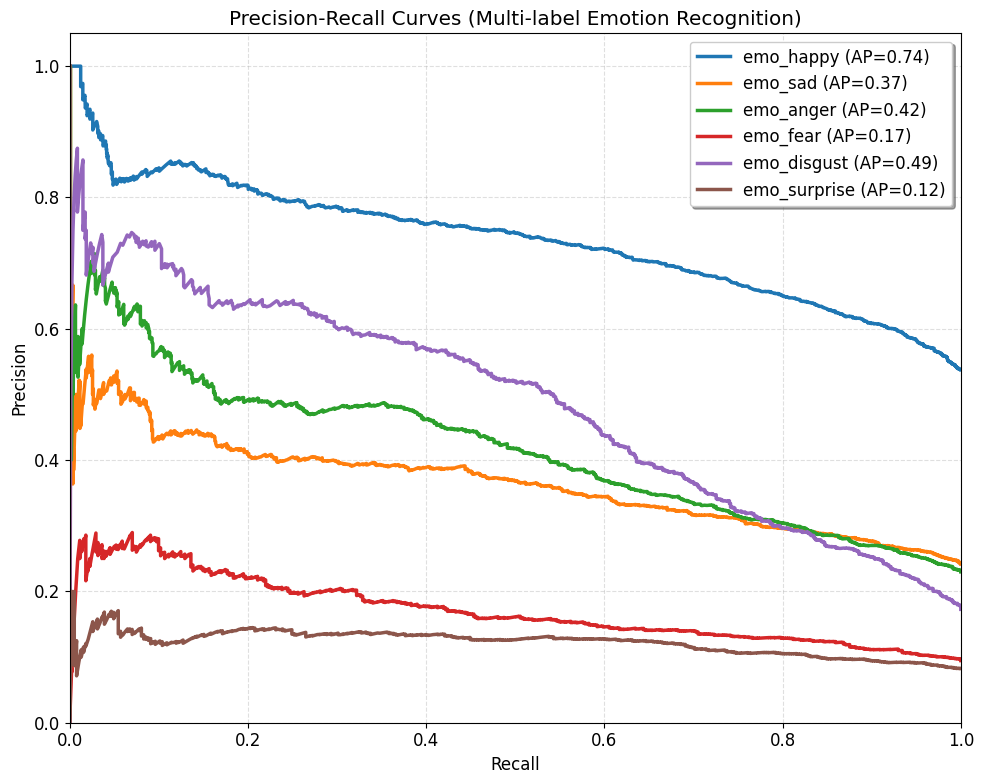

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Assume EMO, y_true, and probs have been loaded in previous steps
# If not loaded, ensure the preceding code blocks have been run

plt.figure(figsize=(10, 8))

# Set font size to give the chart a more academic look
plt.rcParams.update({'font.size': 12})

print("=== Average Precision (AP) per Class ===")

# Define colors, ensuring high contrast
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

for i, name in enumerate(EMO):
    # Check if the class has any positive samples (support > 0)
    if y_true[:, i].sum() > 0:
        prec, rec, _ = precision_recall_curve(y_true[:, i], probs[:, i])
        ap = average_precision_score(y_true[:, i], probs[:, i])

        # Print score
        print(f"{name:<15} AP = {ap:.4f}")

        # Plot the curve
        plt.plot(rec, prec, lw=2.5, color=colors[i], label=f'{name} (AP={ap:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (Multi-label Emotion Recognition)")

# Place the legend in a suitable location
plt.legend(loc="upper right", frameon=True, shadow=True)

# Grid lines
plt.grid(alpha=0.4, linestyle='--')

# Set axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

In [ ]:
!PYTHONPATH=. python scripts/infer/mosei_plot_metrics.py \
  --infer_dir /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/infer_outputs \
  --ckpt /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/best_mosei_fusion_decoder.pt \
  --out_dir /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/plots

--- Plotting metrics for TEST set ---
Using thresholds: [0.05 0.05 0.15 0.2  0.25 0.35]
--- Overall Metrics Saved ---
micro-F1: 0.4802
macro-F1: 0.4251
macro-AUC: 0.6977

[Plot] Combined PR curve for publication saved to: /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/plots/test_combined_PR_curve.png

✅ All plots saved to: /content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_v2/plots
